In [ ]:
# !pip install transformers

In [2]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, AlbertTokenizer, AlbertConfig, AlbertModel
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from sklearn import metrics

In [151]:
train_data = pd.read_json('/kaggle/input/ru-paraphraser/train.jsonl', lines=True)
train_data.head(2)

,id,id_1,id_2,text_1,text_2,class
0,1,201,8159,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0
1,2,202,8158,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0


In [152]:
train_data['content'] = train_data.text_1 + ' | ' + train_data.text_2
train_data.drop(['id_1','id_2'], axis=1, inplace=True)
train_text = train_data.content
train_labels = train_data['class']

In [153]:
test_data = pd.read_json('/kaggle/input/ru-paraphraser/test.jsonl', lines=True)
test_data.head(2)

,id,id_1,id_2,text_1,text_2,class
0,25349,34420,34421,Цены на нефть восстанавливаются,Парламент Словакии поблагодарил народы бывшего...,-1
1,25360,34438,34439,"""Гоголь-центр"" покажет видеозапись скандальног...",Кехман запретил «Гоголь-центру» показывать вид...,-1


In [154]:
test_data['content'] = test_data.text_1 + ' | ' + test_data.text_2
test_data.drop(['id_1','id_2'], axis=1, inplace=True)
test_text = test_data.content
test_labels = test_data['class']

In [155]:
train_labels.unique()

array([ 0, -1,  1])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


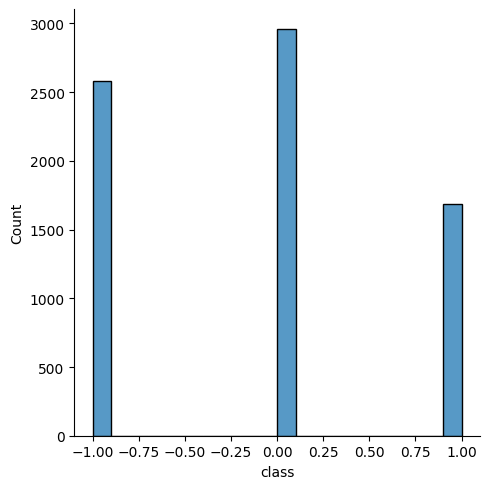

In [156]:
sns.displot(train_labels)

In [157]:
train = pd.concat([train_text, train_labels], sort=False, axis=1)
test = pd.concat([test_text, test_labels], sort=False, axis=1)

In [158]:
train['class'] = train['class'].astype(str)
test['class'] = test['class'].astype(str)
train.loc[train['class'] =='-1', 'class'] = '2'
test.loc[test['class'] =='-1', 'class'] = '2'

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


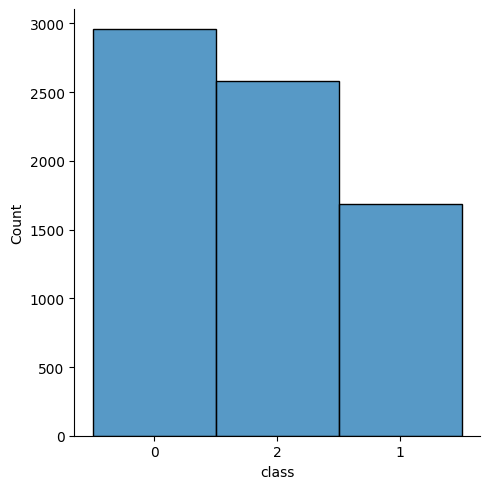

In [159]:
sns.displot(train['class'])

In [160]:
for i in ['0', '1', '2']:
    train[i] = train['class'].apply(lambda x: 1 if i in x else 0)
    test[i] = test['class'].apply(lambda x: 1 if i in x else 0)

In [117]:
train.drop(['class'], axis=1, inplace=True)
test.drop(['class'], axis=1, inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [118]:
train.head(2)

,content,0,1,2
0,Полицейским разрешат стрелять на поражение по ...,1,0,0
1,Право полицейских на проникновение в жилище ре...,1,0,0


In [119]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [120]:
target_cols = [col for col in train.columns if col not in ['content']]
target_cols

['0', '1', '2']

-------------------------------

In [17]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained('blinoff/roberta-base-russian-v0', max_len=512)

tokenizer_config.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [18]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [19]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [20]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [22]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('blinoff/roberta-base-russian-v0')
        self.fc = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_R = BERTClass()
model_R.to(device);

model.safetensors:   0%|          | 0.00/500M [00:00<?, ?B/s]

In [23]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_R.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [90]:
def train(epoch, model):
    model.train()
    for _,data in enumerate(train_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      if _%100 == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

In [91]:
def test(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [92]:
def test_model_by_train(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_for_test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [27]:
# MAX_LEN = 200
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5 ruroberta
for epoch in range(EPOCHS):
  train(epoch, model_R)

Epoch: 0, Loss:  0.6798262000083923
Epoch: 0, Loss:  0.5643655061721802
Epoch: 0, Loss:  0.5888096690177917
Epoch: 1, Loss:  0.5856021642684937
Epoch: 1, Loss:  0.5574392080307007
Epoch: 1, Loss:  0.6288100481033325
Epoch: 2, Loss:  0.5242875218391418
Epoch: 2, Loss:  0.5946784019470215
Epoch: 2, Loss:  0.4357779026031494


In [41]:
for epoch in range(2):
  train(epoch, model_R)

Epoch: 0, Loss:  0.4162341058254242
Epoch: 0, Loss:  0.3815734088420868
Epoch: 0, Loss:  0.48269709944725037
Epoch: 1, Loss:  0.42944854497909546
Epoch: 1, Loss:  0.39328640699386597
Epoch: 1, Loss:  0.254337877035141


In [42]:
test_outputs, test_targets = test(model_R)

In [43]:
train_outputs, train_targets = test_model_by_train(model_R)

In [44]:
np.savetxt("Roberta_outputs_3cl_2.csv", test_outputs, delimiter=";")
np.savetxt("Roberta_outputs_train_3cl_2.csv", train_outputs, delimiter=";")

In [45]:
train_outputs = np.array(train_outputs) >= 0.5

In [46]:
targets = []
for each in train_targets:
    if each[0] > 0:
        targets.append(0)
    else:
        if each[1] > 0:
           targets.append(1)
        else:
           targets.append(2)

In [47]:
outputs = []
for each in train_outputs:
    if each[0]:
        outputs.append(0)
    else:
        if each[1]:
           outputs.append(1)
        else:
           outputs.append(2)

In [48]:
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.9056316590563166
F1 Score (Micro) = 0.9056316590563166
F1 Score (Macro) = 0.9004552293966602
F1 Score (Weighted) = 0.9053833859958907


In [52]:
from sklearn import metrics

test_outputs = np.array(test_outputs) >= 0.5
accuracy = metrics.accuracy_score(test_targets, test_outputs)
f1_score_micro = metrics.f1_score(test_targets, test_outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets, test_outputs, average='macro')
f1_score_weighted = metrics.f1_score(test_targets, test_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.39293139293139295
F1 Score (Micro) = 0.4163019693654267
F1 Score (Macro) = 0.38984107847952637
F1 Score (Weighted) = 0.4173432141317143


In [53]:
new_outputs = []
for each in test_outputs:
    if each[0]:
      new_outputs.append(0)
    elif each[1]:
      new_outputs.append(1)
    else:
      new_outputs.append(2)

In [54]:
new_targets = []
for each in test_targets:
    if each[0]:
      new_targets.append(0)
    elif each[1]:
      new_targets.append(1)
    else:
      new_targets.append(2)

Results for RoBERTa:

In [55]:
accuracy = metrics.accuracy_score(new_targets, new_outputs)
f1_score_micro = metrics.f1_score(new_targets, new_outputs, average='micro')
f1_score_macro = metrics.f1_score(new_targets, new_outputs, average='macro')
f1_score_weighted = metrics.f1_score(new_targets, new_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.44542619542619544
F1 Score (Micro) = 0.44542619542619544
F1 Score (Macro) = 0.41319158955180607
F1 Score (Weighted) = 0.44509002299390066


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

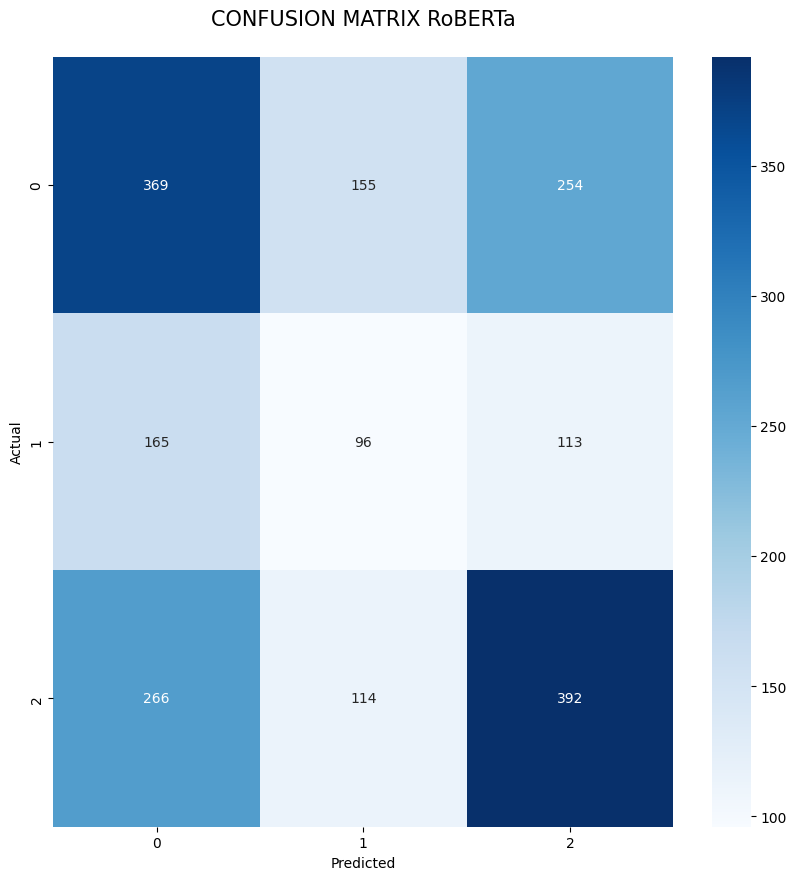

In [62]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=15)

-------------------------------------

#### Next model:

In [82]:
tokenizer = AutoTokenizer.from_pretrained('linhd-postdata/alberti-bert-base-multilingual-cased', max_len=512)

In [83]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [84]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [85]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [86]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [87]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.gpt = AutoModel.from_pretrained('linhd-postdata/alberti-bert-base-multilingual-cased')
        self.fc = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.gpt(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_A = BERTClass()
model_A.to(device);

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at linhd-postdata/alberti-bert-base-multilingual-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_A.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [93]:
for epoch in range(EPOCHS):
  train(epoch, model_A)

Epoch: 0, Loss:  0.697253406047821
Epoch: 0, Loss:  0.551819920539856
Epoch: 0, Loss:  0.5279231071472168
Epoch: 1, Loss:  0.4415323734283447
Epoch: 1, Loss:  0.3973623514175415
Epoch: 1, Loss:  0.38216567039489746
Epoch: 2, Loss:  0.37842047214508057
Epoch: 2, Loss:  0.4184333086013794
Epoch: 2, Loss:  0.3332211375236511


In [94]:
test_outputs_A, test_targets_A = test(model_A)

In [95]:
train_outputs_A, train_targets_A = test_model_by_train(model_A)

In [96]:
np.savetxt("Alberti_outputs_train_cl3.csv", train_outputs_A, delimiter=";")
np.savetxt("Alberti_outputs_cl3.csv", test_outputs_A, delimiter=";")

In [97]:
from sklearn import metrics

outputs = np.array(test_outputs_A) >= 0.5
accuracy = metrics.accuracy_score(test_targets_A, outputs)
f1_score_micro = metrics.f1_score(test_targets_A, outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets_A, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.5145530145530145
F1 Score (Micro) = 0.5669693530079456
F1 Score (Macro) = 0.5613259580889348


In [98]:
new_outputs = []
for each in test_outputs_A:
    if each[0]:
      new_outputs.append(0)
    elif each[1]:
      new_outputs.append(1)
    else:
      new_outputs.append(2)

In [99]:
new_targets = []
for each in test_targets_A:
    if each[0]:
      new_targets.append(0)
    elif each[1]:
      new_targets.append(1)
    else:
      new_targets.append(2)

In [100]:
accuracy = metrics.accuracy_score(new_targets, new_outputs)
f1_score_micro = metrics.f1_score(new_targets, new_outputs, average='micro')
f1_score_macro = metrics.f1_score(new_targets, new_outputs, average='macro')
f1_score_weighted = metrics.f1_score(new_targets, new_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.40436590436590436
F1 Score (Micro) = 0.40436590436590436
F1 Score (Macro) = 0.1919565753762645
F1 Score (Weighted) = 0.23286208260301525


Text(0.5, 1.0, 'CONFUSION MATRIX\n')

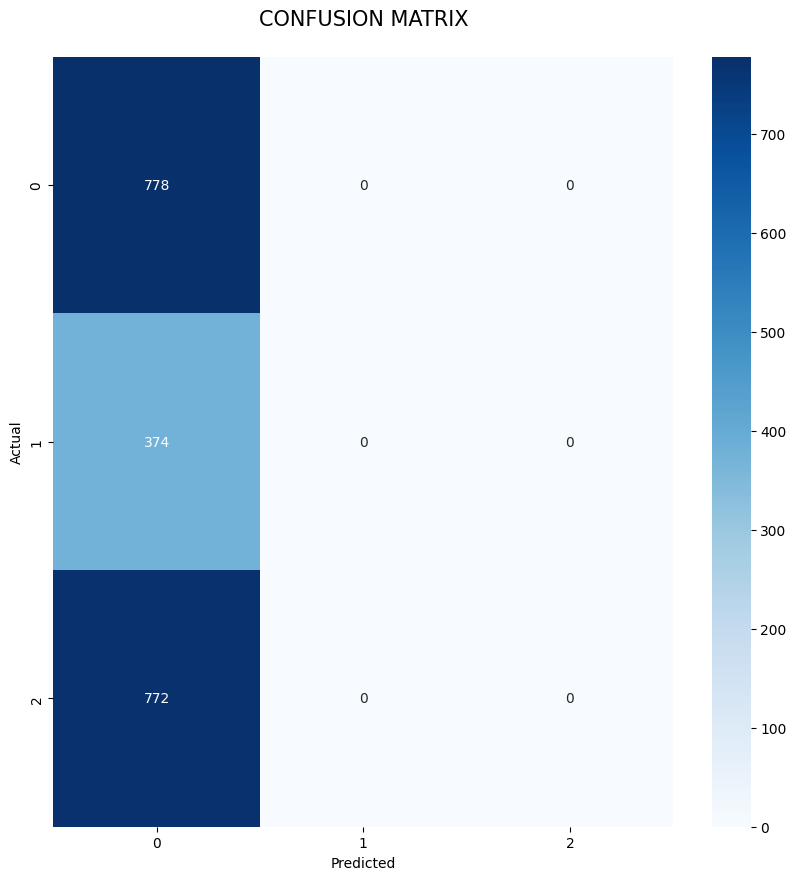

In [101]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)

-------------------------------

In [121]:
tokenizer = AutoTokenizer.from_pretrained('ai-forever/ruBert-base', max_len=512)

In [122]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [123]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [124]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [125]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [128]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('ai-forever/ruBert-base')
        self.fc = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_B = BERTClass()
model_B.to(device);

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [129]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_B.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [130]:
def train(epoch, model):
    model.train()
    for _,data in enumerate(train_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      if _%100 == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

In [131]:
def test(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [132]:
def test_model_by_train(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_for_test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [133]:
# MAX_LEN = 200
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5 ruroberta
for epoch in range(EPOCHS):
  train(epoch, model_B)

Epoch: 0, Loss:  0.669029712677002
Epoch: 0, Loss:  0.4876694083213806
Epoch: 0, Loss:  0.4377323091030121
Epoch: 1, Loss:  0.305864542722702
Epoch: 1, Loss:  0.3793109357357025
Epoch: 1, Loss:  0.4674167335033417
Epoch: 2, Loss:  0.2773802876472473
Epoch: 2, Loss:  0.19844476878643036
Epoch: 2, Loss:  0.24398867785930634


In [134]:
test_outputs, test_targets = test(model_B)

In [135]:
train_outputs, train_targets = test_model_by_train(model_B)

In [136]:
np.savetxt("Bert_outputs_paraphrases_cl3.csv", test_outputs, delimiter=";")
np.savetxt("Bert_outputs_train_paraphrases_cl3.csv", train_outputs, delimiter=";")

In [137]:
train_outputs = np.array(train_outputs) >= 0.5

In [138]:
targets = []
for each in train_targets:
    if each[0] > 0:
        targets.append(0)
    else:
#         targets.append(1)
        if each[1] > 0:
           targets.append(1)
        else:
           targets.append(2)

In [139]:
outputs = []
for each in train_outputs:
    if each[0]:
        outputs.append(0)
    else:
#         outputs.append(1)
        if each[1]:
           outputs.append(1)
        else:
           outputs.append(2)

In [140]:
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.9344126193441262
F1 Score (Micro) = 0.9344126193441262
F1 Score (Macro) = 0.9336254533987853
F1 Score (Weighted) = 0.9342642157442861


In [141]:
test_outputs = np.array(test_outputs) >= 0.5
accuracy = metrics.accuracy_score(test_targets, test_outputs)
f1_score_micro = metrics.f1_score(test_targets, test_outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets, test_outputs, average='macro')
f1_score_weighted = metrics.f1_score(test_targets, test_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.670997920997921
F1 Score (Micro) = 0.6813764118728658
F1 Score (Macro) = 0.6580836292431617
F1 Score (Weighted) = 0.6804240189215993


In [142]:
new_outputs = []
for each in test_outputs:
    if each[0]:
      new_outputs.append(0)
    elif each[1]:
      new_outputs.append(1)
    else:
      new_outputs.append(2)

In [143]:
new_targets = []
for each in test_targets:
    if each[0]:
      new_targets.append(0)
    elif each[1]:
      new_targets.append(1)
    else:
      new_targets.append(2)

In [144]:
accuracy = metrics.accuracy_score(new_targets, new_outputs)
f1_score_micro = metrics.f1_score(new_targets, new_outputs, average='micro')
f1_score_macro = metrics.f1_score(new_targets, new_outputs, average='macro')
f1_score_weighted = metrics.f1_score(new_targets, new_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6787941787941788
F1 Score (Micro) = 0.6787941787941788
F1 Score (Macro) = 0.654651531308165
F1 Score (Weighted) = 0.6765658185044542


Text(0.5, 1.0, 'CONFUSION MATRIX RuBERT\n')

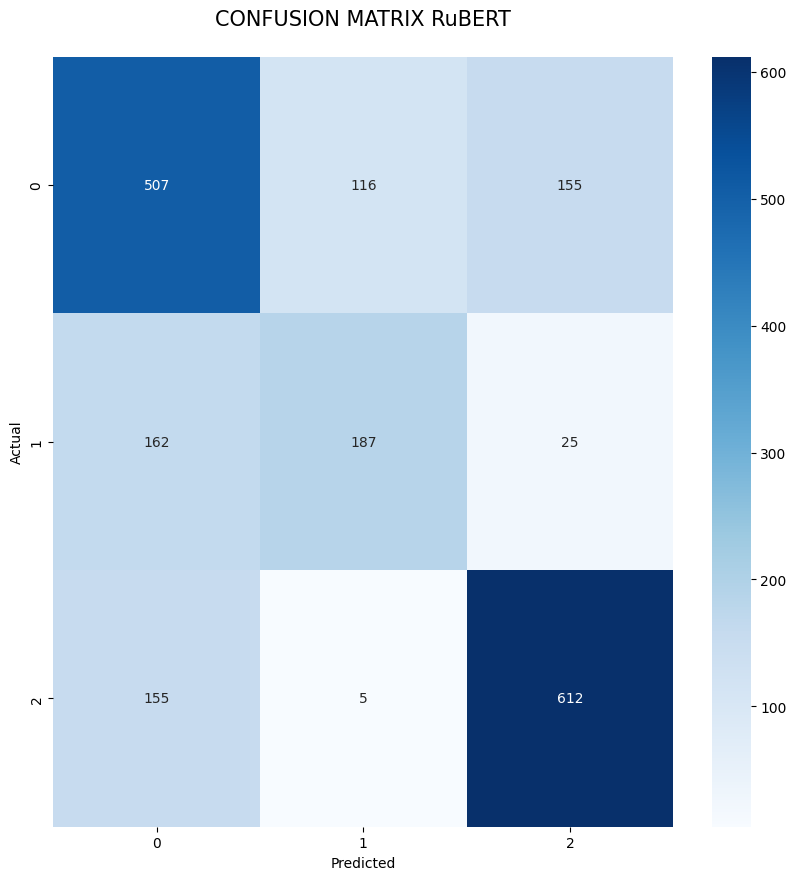

In [145]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RuBERT\n", size=15)

-----------------------------------------------------------

In [146]:
df_train_R = pd.read_csv("/kaggle/input/outputs/Roberta_outputs_train_3cl_2.csv", header=None, sep=';')
df_train_A = pd.read_csv("/kaggle/input/outputs/Alberti_outputs_train_cl3 (1).csv", header=None, sep=';')
df_train_B = pd.read_csv("/kaggle/input/outputs/Bert_outputs_train_paraphrases_cl3 (1).csv", header=None, sep=';')
df_train_R = df_train_R.rename(columns={0: 'R_0', 1: 'R_1', 2: 'R_2'})
df_train_A = df_train_A.rename(columns={0: 'A_0', 1: 'A_1', 2: 'A_2'})
df_train_B = df_train_B.rename(columns={0: 'B_0', 1: 'B_1', 2: 'B_2'})

In [147]:
df_train_B

,B_0,B_1,B_2
0,0.683022,0.307104,0.013070
1,0.824676,0.056103,0.076944
2,0.763282,0.025733,0.134804
3,0.012457,0.006584,0.986887
4,0.874308,0.079832,0.039566
...,...,...,...
7222,0.791019,0.016871,0.216454
7223,0.014700,0.006385,0.982583
7224,0.013424,0.005550,0.983614
7225,0.022206,0.003640,0.975234


In [148]:
df_train = pd.concat([
    df_train_R, df_train_A, df_train_B], axis=1)

In [162]:
df_train

,R_0,R_1,R_2,A_0,A_1,A_2,B_0,B_1,B_2
0,0.675350,0.277331,0.033007,0.463707,0.519746,0.026568,0.683022,0.307104,0.013070
1,0.821579,0.060877,0.113309,0.643176,0.191755,0.157972,0.824676,0.056103,0.076944
2,0.575182,0.312664,0.033259,0.660749,0.259909,0.125798,0.763282,0.025733,0.134804
3,0.011901,0.010248,0.985004,0.041183,0.009561,0.954049,0.012457,0.006584,0.986887
4,0.893209,0.078478,0.022424,0.617567,0.059773,0.223872,0.874308,0.079832,0.039566
...,...,...,...,...,...,...,...,...,...
7222,0.893738,0.070691,0.028885,0.655120,0.317599,0.045206,0.791019,0.016871,0.216454
7223,0.010198,0.010465,0.989327,0.013810,0.010603,0.985020,0.014700,0.006385,0.982583
7224,0.008598,0.010662,0.986271,0.012167,0.011032,0.986936,0.013424,0.005550,0.983614
7225,0.029687,0.007529,0.965704,0.075362,0.014200,0.905353,0.022206,0.003640,0.975234


In [163]:
y_train = train['class']
y_train

0       0
1       0
2       0
3       2
4       0
       ..
7222    0
7223    2
7224    2
7225    2
7226    2
Name: class, Length: 7227, dtype: object

In [164]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, y_train)

LinearSVC(C=0.5, class_weight='balanced', max_iter=100000, random_state=42)

In [166]:
df_test_R = pd.read_csv("/kaggle/input/outputs/Roberta_outputs_3cl_2.csv", header=None, sep=';')
df_test_A = pd.read_csv("/kaggle/input/outputs/Alberti_outputs_cl3 (1).csv", header=None, sep=';')
df_test_B = pd.read_csv("/kaggle/input/outputs/Bert_outputs_paraphrases_cl3 (1).csv", header=None, sep=';')
df_test_R = df_test_R.rename(columns={0: 'R_0', 1: 'R_1', 2: 'R_2'})
df_test_A = df_test_A.rename(columns={0: 'A_0', 1: 'A_1', 2: 'A_2'})
df_test_B = df_test_B.rename(columns={0: 'B_0', 1: 'B_1', 2: 'B_2'})

In [167]:
df_test = pd.concat([
    df_test_R, df_test_A, df_test_B], axis=1)

CatBoost

In [165]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=500)
clf.fit(df_train, y_train)

Learning rate set to 0.157217
0:	learn: 0.8406761	total: 62.1ms	remaining: 31s
1:	learn: 0.6787636	total: 67.7ms	remaining: 16.9s
2:	learn: 0.5620601	total: 73.5ms	remaining: 12.2s
3:	learn: 0.4736753	total: 79.3ms	remaining: 9.83s
4:	learn: 0.4060632	total: 84.7ms	remaining: 8.39s
5:	learn: 0.3529394	total: 90.3ms	remaining: 7.44s
6:	learn: 0.3097892	total: 96.2ms	remaining: 6.77s
7:	learn: 0.2738793	total: 102ms	remaining: 6.27s
8:	learn: 0.2441541	total: 108ms	remaining: 5.9s
9:	learn: 0.2190886	total: 114ms	remaining: 5.59s
10:	learn: 0.2003430	total: 120ms	remaining: 5.32s
11:	learn: 0.1826500	total: 125ms	remaining: 5.09s
12:	learn: 0.1681300	total: 131ms	remaining: 4.9s
13:	learn: 0.1559141	total: 137ms	remaining: 4.75s
14:	learn: 0.1462886	total: 142ms	remaining: 4.61s
15:	learn: 0.1377008	total: 148ms	remaining: 4.48s
16:	learn: 0.1304025	total: 154ms	remaining: 4.37s
17:	learn: 0.1239092	total: 160ms	remaining: 4.28s
18:	learn: 0.1182427	total: 166ms	remaining: 4.2s
19:	learn

In [168]:
y_pred = clf.predict(df_test)

In [169]:
test_labels = test['class']
test_labels

0       2
1       2
2       2
3       2
4       2
       ..
1919    1
1920    0
1921    2
1922    2
1923    2
Name: class, Length: 1924, dtype: object

In [171]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.646049896049896
F1 Score (Micro) = 0.646049896049896
F1 Score (Macro) = 0.6223730027553517
F1 Score (Weighted) = 0.6456866609815435


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

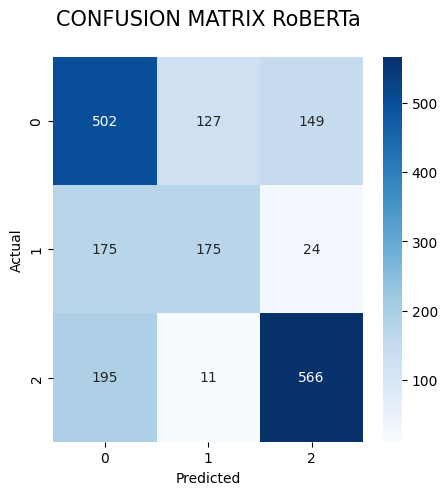

In [170]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=15)

In [172]:
from sklearn.svm import LinearSVC
import optuna
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [173]:
X_train, X_valid, train_labels, valid_labels = train_test_split(df_train, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)

In [174]:
X_train

,R_0,R_1,R_2,A_0,A_1,A_2,B_0,B_1,B_2
3035,0.728991,0.121633,0.091726,0.676624,0.279289,0.064821,0.857563,0.049595,0.079681
6229,0.156595,0.830288,0.006224,0.606032,0.252634,0.134932,0.090732,0.883331,0.011710
5637,0.679927,0.016358,0.371107,0.553328,0.150134,0.259809,0.894651,0.041603,0.069925
5131,0.903979,0.072899,0.016634,0.589855,0.396665,0.055436,0.881360,0.058480,0.060200
5483,0.932792,0.034408,0.041854,0.588815,0.181182,0.162780,0.883697,0.080734,0.031115
...,...,...,...,...,...,...,...,...,...
6042,0.923815,0.061375,0.016918,0.838493,0.163785,0.045929,0.842524,0.047483,0.096485
1820,0.011387,0.010411,0.989989,0.106947,0.019665,0.877756,0.015567,0.004988,0.982342
6485,0.073670,0.925331,0.046658,0.386147,0.488306,0.074741,0.273417,0.718724,0.011056
4989,0.824775,0.158398,0.004606,0.728818,0.211730,0.095861,0.890525,0.092132,0.027724


In [175]:
def objective(trial):
    global X_train, train_labels, X_valid, valid_labels

    c = trial.suggest_float("lr_c", 1e-2, 1e3, log=True)

    clf = LogisticRegression(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train, train_labels)

    return metrics.f1_score(clf.predict(X_valid), valid_labels, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2024-05-04 07:28:47,056] A new study created in memory with name: no-name-43501c0f-ec04-4059-8159-2cbfc80a5e6b
[I 2024-05-04 07:28:47,215] Trial 0 finished with value: 0.9593723073377326 and parameters: {'lr_c': 1.2059264853019795}. Best is trial 0 with value: 0.9593723073377326.
[I 2024-05-04 07:28:47,288] Trial 1 finished with value: 0.9562644404099929 and parameters: {'lr_c': 0.13199480042910897}. Best is trial 0 with value: 0.9593723073377326.
[I 2024-05-04 07:28:47,427] Trial 2 finished with value: 0.9586159823570638 and parameters: {'lr_c': 5.056989824799094}. Best is trial 0 with value: 0.9593723073377326.
[I 2024-05-04 07:28:47,498] Trial 3 finished with value: 0.9562644404099929 and parameters: {'lr_c': 0.11236388844851464}. Best is trial 0 with value: 0.9593723073377326.
[I 2024-05-04 07:28:47,572] Trial 4 finished with value: 0.9562644404099929 and parameters: {'lr_c': 0.15659788364196933}. Best is trial 0 with value: 0.9593723073377326.
[I 2024-05-04 07:28:47,794] Trial 

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9593723073377326], datetime_start=datetime.datetime(2024, 5, 4, 7, 28, 47, 57690), datetime_complete=datetime.datetime(2024, 5, 4, 7, 28, 47, 215595), params={'lr_c': 1.2059264853019795}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr_c': FloatDistribution(high=1000.0, log=True, low=0.01, step=None)}, trial_id=0, value=None)


In [176]:
clf = LogisticRegression(C=1.2, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, y_train)

LogisticRegression(C=1.2, class_weight='balanced', max_iter=100000,
                   random_state=42)

In [177]:
y_pred = clf.predict(df_test)

In [178]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6481288981288982
F1 Score (Micro) = 0.6481288981288982
F1 Score (Macro) = 0.6301961304249949


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

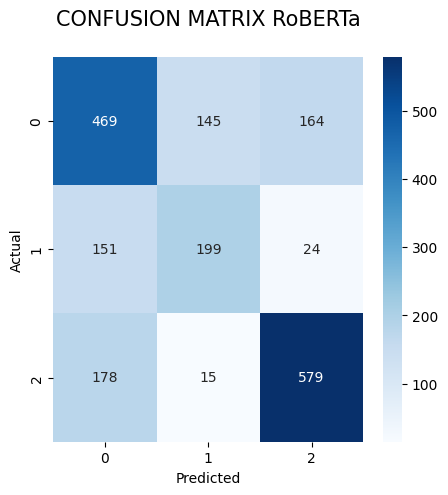

In [179]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=15)

In [187]:
def objective(trial):
    global X_train, train_labels, X_valid, valid_labels

    c = trial.suggest_float("svc_c", 1e-3, 1e3, log=True)

    clf = LinearSVC(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train, train_labels)

    return metrics.f1_score(clf.predict(X_valid), valid_labels, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print(study.best_trial)

[I 2024-05-04 07:38:16,034] A new study created in memory with name: no-name-b24b1c0c-8cc9-4c47-9f85-df89d7e0f1cd
[I 2024-05-04 07:38:16,104] Trial 0 finished with value: 0.9578517998864444 and parameters: {'svc_c': 1.7742919574891531}. Best is trial 0 with value: 0.9578517998864444.
[I 2024-05-04 07:38:22,741] Trial 1 finished with value: 0.9572039216875458 and parameters: {'svc_c': 478.7982768296457}. Best is trial 0 with value: 0.9578517998864444.
[I 2024-05-04 07:38:22,885] Trial 2 finished with value: 0.9572039216875458 and parameters: {'svc_c': 7.465995751059121}. Best is trial 0 with value: 0.9578517998864444.
[I 2024-05-04 07:38:22,929] Trial 3 finished with value: 0.957093828786784 and parameters: {'svc_c': 0.27842999317016504}. Best is trial 0 with value: 0.9578517998864444.
[I 2024-05-04 07:38:22,969] Trial 4 finished with value: 0.9577067212875314 and parameters: {'svc_c': 0.04537558318991475}. Best is trial 0 with value: 0.9578517998864444.
[I 2024-05-04 07:38:23,064] Tria

FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.9612199834502695], datetime_start=datetime.datetime(2024, 5, 4, 7, 38, 23, 376995), datetime_complete=datetime.datetime(2024, 5, 4, 7, 38, 23, 427431), params={'svc_c': 0.0010555728065849272}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_c': FloatDistribution(high=1000.0, log=True, low=0.001, step=None)}, trial_id=10, value=None)


In [188]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=0.001, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, y_train)

LinearSVC(C=0.001, class_weight='balanced', max_iter=100000, random_state=42)

In [189]:
y_pred = clf.predict(df_test)

In [190]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6574844074844075
F1 Score (Micro) = 0.6574844074844075
F1 Score (Macro) = 0.6388701365015483


Text(0.5, 1.0, 'CONFUSION MATRIX\n')

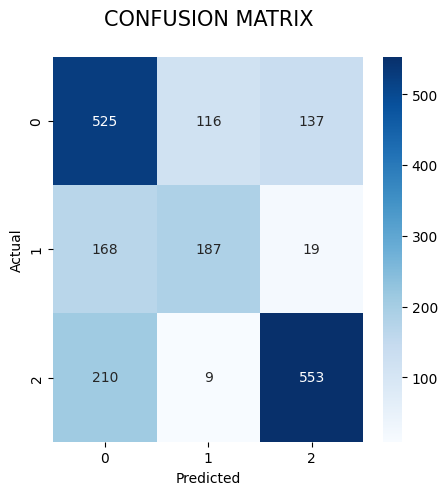

In [191]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)